In [19]:
import h5py
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [5]:
fname = 'GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160701_t1814088_e1819492_b24237_c20180423131243009989_noaa_ops_reproj.h5'
path = '/Volumes/INTENSO/kcl-ltss-bioatm/raw/reprojected_viirs/h5'
sdr_path = os.path.join(path, fname)
sdr = h5py.File(sdr_path,  "r")

In [22]:
bands = ['1', '4', '5', '6', '7', '10', '11', '12', '15']
rgb = []
for i, band in enumerate(bands):
    # extract band data and place in array
    image = sdr['VIIRS-M' + band][:]
    
    if i == 0:
        image_array = np.zeros((image.size, len(bands)))
        
    if i in [0,1,2]:
        rgb.append(image)
    
    image_array[:, i] = image.flatten()

In [16]:
path_to_rf_model = '/Volumes/INTENSO/kcl-ltss-bioatm/interim/models/rf_model_64_trees.pickle'
rf_model = pickle.load(open(path_to_rf_model, 'rb'))

/Users/dnf/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/dnf/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [17]:
mask = rf_model.predict(image_array)

In [18]:
mask = mask.reshape(image.shape)

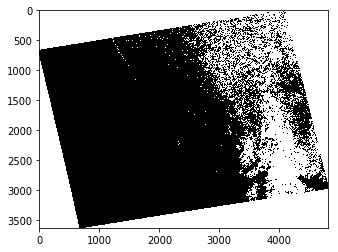

In [25]:
fig = plt.figure()
plt.imshow(mask, cmap='gray', interpolation='none')
plt.show()

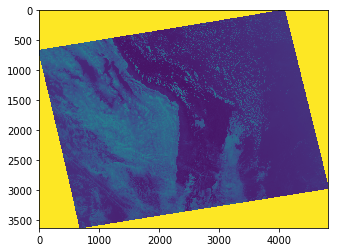

In [31]:
plt.imshow(np.dstack(rgb)[:,:,0], vmin=0)
plt.show()